In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
import time

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 100

# SIS model

$$\frac{dS}{dt} = -\beta S I + \gamma I \\
\frac{dI}{dt} = \beta SI - \gamma I,$$
where $I_0, S_0$ - initial conditions, $S\left(t\right) + I\left(t\right) = N$ - total population, $\beta$ - infectivity coefficient, $\gamma$ - recovery coefficient. 

- train on [0,20], predict on [0,25]

In [2]:
# Parameters
beta = 0.001  # Rate of infection
gamma = 0.1  # Rate of recovery

In [3]:
# Generate synthetic data
torch.manual_seed(0)
x_train = torch.rand(1000) * 20  # Range [0, 20] with 1000 points
x_train, _ = torch.sort(x_train)

In [4]:
# Function defining the SIS model equations
def SIS_model(t, Y):
    S, I = Y
    dSdx = -beta*S*I+gamma*I
    dIdx = beta*S*I-gamma*I
    return [dSdx, dIdx]

x_span = (0, 20)  # Time span for integration
x_eval = x_train.numpy()  # Time points for evaluation

# Initial conditions
y0 = [990, 10]

# Solve the ODEs
sol = solve_ivp(SIS_model, x_span, y0, dense_output=True, rtol=10**(-6))

y_eval = sol.sol(x_eval)

In [5]:
y1_true = torch.from_numpy(y_eval[0])
y2_true = torch.from_numpy(y_eval[1])

In [6]:
def f1(y1, y2):
    return -beta*y1*y2+gamma*y2
def f2(y1, y2):
    return beta*y1*y2-gamma*y2

In [7]:
# Calculate the true local truncation error
def true_truncation_error(x_i, x_j, y1_i, y1_j, y2_i, y2_j, eq):
    if eq == 'f1':
        return (1/(x_j - x_i) ** 2)*(y1_j - y1_i - (x_j - x_i) * f1(y1_i, y2_i))
    elif eq == 'f2':
        return (1/(x_j - x_i) ** 2)*(y2_j - y2_i - (x_j - x_i) * f2(y1_i, y2_i))

In [8]:
# Generate training samples for the neural network
N = len(x_train)
samples_y1 = []
samples_y2 = []
for i in range(N):
    for j in range(i + 1, N):
        x_i, x_j = x_train[i], x_train[j]
        y1_i, y1_j = y1_true[i], y1_true[j]
        y2_i, y2_j = y2_true[i], y2_true[j]
        samples_y1.append((x_i, x_j, y1_i, true_truncation_error(x_i, x_j, y1_i, y1_j, y2_i, y2_j, 'f1')))
        samples_y2.append((x_i, x_j, y2_i, true_truncation_error(x_i, x_j, y1_i, y1_j, y2_i, y2_j, 'f2')))

# Shuffle the samples
np.random.shuffle(samples_y1)
np.random.shuffle(samples_y2)

In [9]:
# Prepare the data for training
X1 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i, _ in samples_y1], dtype=torch.float32) # x_i, x_j, y_i
X2 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i, _ in samples_y2], dtype=torch.float32) # x_i, x_j, y_i
y1 = torch.tensor([R for _, _, _, R in samples_y1], dtype=torch.float32) # truncation error for this x_i, x_j, y_i
y2 = torch.tensor([R for _, _, _, R in samples_y2], dtype=torch.float32) # truncation error for this x_i, x_j, y_i


In [10]:
# Define the neural network model
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(3, 80)
        self.fc2 = nn.Linear(80, 80)
        self.fc3 = nn.Linear(80, 80)
        self.fc4 = nn.Linear(80, 80)
        self.fc5 = nn.Linear(80, 80)
        self.fc6 = nn.Linear(80, 80)
        self.fc7 = nn.Linear(80, 80)
        self.fc8 = nn.Linear(80, 80)
        self.fc9 = nn.Linear(80, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = self.fc9(x)
        return x

In [11]:
# Define the custom loss function
def custom_loss(y_true, y_pred):
    error = torch.abs(y_pred - y_true)
    loss = 2 / (N * (N - 1)) * torch.sum(error)
    return loss

In [12]:
# Generate synthetic data - data for testing
torch.manual_seed(0)
h = 0.01
x_test = torch.arange(0, 25, h)  # Range [0, 25] 
N = len(x_test)

In [13]:
x_span = (0, 25)  # Time span for integration
x_eval = x_test.numpy()  # Time points for evaluation

# Initial conditions
y0 = [990, 10]

# Solve the ODEs
sol = solve_ivp(SIS_model, x_span, y0, dense_output=True)

y_eval = sol.sol(x_eval)

In [14]:
y1_test_true = torch.from_numpy(y_eval[0])
y2_test_true = torch.from_numpy(y_eval[1])

In [15]:
# Compute the Euler's method solution

# Function to compute the derivatives (Lotka-Volterra equations)
def SIS_model(y1, y2):
    dy1_dx = -beta*y1*y2+gamma*y2
    dy2_dx = beta*y1*y2-gamma*y2
    return dy1_dx, dy2_dx

# Initial populations
y1_0 = 990  # Initial prey population
y2_0 = 10  # Initial predator population

# Time parameters
t0 = 0    # Initial time
T = 25   # Total time
dt = 0.01  # Time step size - h

# Number of time steps
num_steps = int(T / dt)

# Arrays to store population values
y1_values = np.zeros(num_steps)
y2_values = np.zeros(num_steps)
time_values = np.linspace(t0, T, num_steps)

# Set initial values
y1_values[0] = y1_0
y2_values[0] = y2_0

# Perform Euler's method
for i in range(num_steps-1):
#     dy1_dx, dy2_dx = SIS_model(y1_values[i], y2_values[i], beta, gamma)
    dy1_dx, dy2_dx = SIS_model(y1_values[i], y2_values[i])
    y1_values[i+1] = y1_values[i] + dt * dy1_dx
    y2_values[i+1] = y2_values[i] + dt * dy2_dx

y1_euler = y1_values
y2_euler = y2_values

In [16]:
x_test_for_NN1 = []
x_test_for_NN2 = []
for i in range(len(x_test)-1):
    x_test_for_NN1.append((x_test[i], x_test[i+1], y1_test_true[i]))  # x_i, x_j, y_i
    x_test_for_NN2.append((x_test[i], x_test[i+1], y2_test_true[i]))  # x_i, x_j, y_i

In [17]:
x_test_for_NN1 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN1], dtype=torch.float32)
x_test_for_NN2 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN2], dtype=torch.float32)

In [20]:
# run the model several times to check robustness of the method
number_of_iterations = 10
y1_finals = []
y2_finals = []
for i in range(number_of_iterations):
    print(i)
    # Create the neural network model
    nn_model_y1 = NNModel()
    nn_model_y2 = NNModel()

    # Define the optimizer
    optimizer_y1 = optim.Adam(nn_model_y1.parameters(), lr=.005)
    optimizer_y2 = optim.Adam(nn_model_y2.parameters(), lr=.005)

    # Train the neural network
    num_epochs = 50
    #losses = []
    for epoch in range(num_epochs):
        optimizer_y1.zero_grad()
        optimizer_y2.zero_grad()

        outputs_y1 = nn_model_y1(X1).flatten()
        outputs_y2 = nn_model_y2(X2).flatten()

        loss = custom_loss(outputs_y1, y1) + custom_loss(outputs_y2, y2)
        loss.backward()

        optimizer_y1.step()
        optimizer_y2.step()
        
    # Predict the truncation error using the neural network
    h = 0.01
    y1_pred = nn_model_y1(x_test_for_NN1)
    y2_pred = nn_model_y2(x_test_for_NN2) 

    y1_pred = y1_pred.detach().numpy().flatten()
    y2_pred = y2_pred.detach().numpy().flatten()

    y1_pred = np.insert(y1_pred,0,0)
    y2_pred = np.insert(y2_pred,0,0)

    # Compute the final solution by adding Euler's method output and the predicted truncation error
    y1_final = y1_euler + h*y1_pred
    y2_final = y2_euler + h*y2_pred

    y1_finals.append(y1_final)
    y2_finals.append(y2_final)

0
1
2
3
4
5
6
7
8
9


In [22]:
# std
std_y1_finals = np.std(y1_finals, axis=0)
std_y2_finals = np.std(y2_finals, axis=0)

df_std_y1y2 = pd.DataFrame({'S': std_y1_finals, 'I': std_y2_finals})

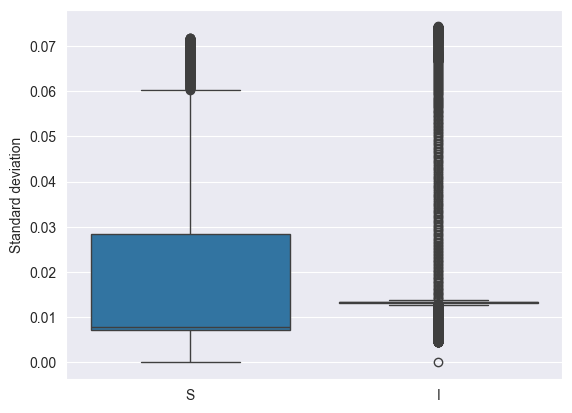

In [23]:
fig, ax = plt.subplots()
ax = sns.boxplot(data=df_std_y1y2)
ax.set(ylabel='Standard deviation')
#fig.savefig('graphs/DEM_std_SIS.pdf')

In [24]:
y1_final = np.mean(y1_finals, axis=0)
y2_final = np.mean(y2_finals, axis=0)

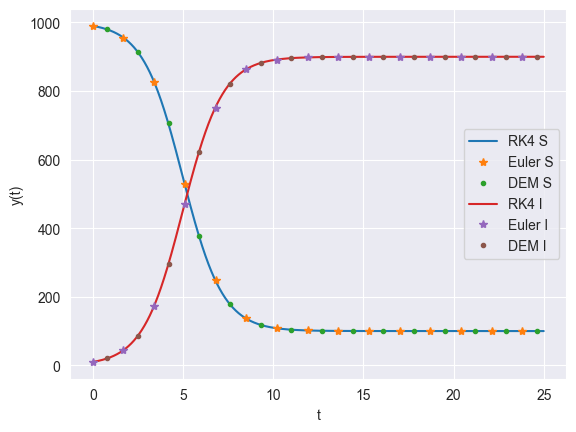

In [25]:
# Plot the solutions
fig, ax = plt.subplots()
plt.plot(x_test.numpy(), y1_test_true.numpy(), label='RK4 S')
plt.plot(x_test.numpy()[::170], y1_euler[::170], '*', label="Euler S")
plt.plot(x_test.numpy()[80::170], y1_final[80::170], '.', label='DEM S')
plt.plot(x_test.numpy(), y2_test_true.numpy(), label='RK4 I')
plt.plot(x_test.numpy()[::170], y2_euler[::170], '*', label="Euler I")
plt.plot(x_test.numpy()[80::170], y2_final[80::170], '.', label='DEM I')
#plt.title("Comparison of solutions of SIS model")
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.grid(True)
plt.show()
#fig.savefig('graphs/DEM_solutions_SIS.pdf')

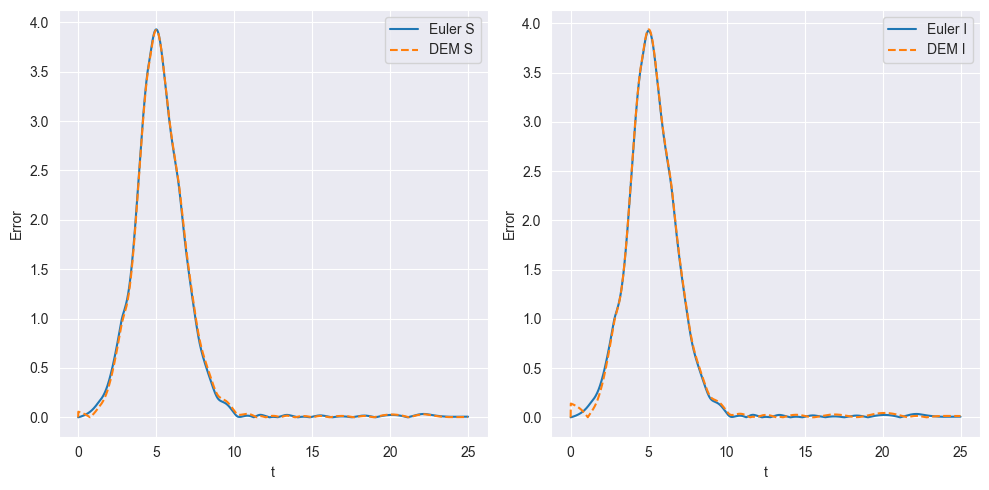

In [26]:
# Plot the errors
# h = 0.01
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(x_test.numpy(), abs(y1_euler-y1_test_true.numpy()), label="Euler S")
axs[0].plot(x_test.numpy(), abs(y1_final-y1_test_true.numpy()), label='DEM S', linestyle='--')
#axs[0].set_title('Comparison of errors of solutions of S from SIS model')
axs[0].set_xlabel('t')
axs[0].set_ylabel('Error')
axs[0].legend()

axs[1].plot(x_test.numpy(), abs(y2_euler-y2_test_true.numpy()), label="Euler I")
axs[1].plot(x_test.numpy(), abs(y2_final-y2_test_true.numpy()), label='DEM I', linestyle='--')
#axs[1].set_title('Comparison of errors of solutions of I from SIS model')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Error')
axs[1].legend()

fig.tight_layout()
#fig.savefig('graphs/DEM_errors_SIS.pdf')

In [35]:
y1_final

array([990.        , 989.85379716, 989.76403871, ..., 100.00339276,
       100.00339163, 100.00339051])

In [37]:
y1_test_true.numpy()

array([990.        , 989.91060727, 989.82042458, ..., 100.00658441,
       100.00653453, 100.00648152])

In [38]:
# Sum of errors
print("Sum of errors for Euler comparing to RK4 solution for y1=S:", round(mae(y1_euler, y1_test_true),3))
print("Sum of errors for Euler comparing to RK4 solution for y2=I:", round(mae(y2_euler, y2_test_true),3))

print("Sum of errors for DEM comparing to RK4 solution for y1=S", round(mae(y1_final, y1_test_true),3))
print("Sum of errors for DEM comparing to RK4 solution for y2=I", round(mae(y2_final, y2_test_true),3))

Sum of errors for Euler comparing to RK4 solution for y1=S: 0.545
Sum of errors for Euler comparing to RK4 solution for y2=I: 0.545
Sum of errors for DEM comparing to RK4 solution for y1=S 0.544
Sum of errors for DEM comparing to RK4 solution for y2=I 0.549


In [80]:
# comparison of the errors for different h - here without averaging over 10 models
h_list = [0.001, 0.01, 0.1, 1, 2, 3]
errors_euler_y1 = []
errors_DEM_y1 = []
errors_euler_y2 = []
errors_DEM_y2 = []
times_euler = []
times_DEM = []
for h in h_list:
    x_test = torch.arange(0, 25, h)  # Range [0, 25] 
    N = len(x_test)
    
    # Function defining the SIS model equations
    def SIS_model(t, Y):
        S, I = Y
        dSdx = -beta*S*I+gamma*I
        dIdx = beta*S*I-gamma*I
        return [dSdx, dIdx]
    
    x_span = (0, 25)  # Time span for integration
    x_eval = x_test.numpy()  # Time points for evaluation

    # Initial conditions
    y0 = [990, 10]
    
    # Solve the ODEs
    sol = solve_ivp(SIS_model, x_span, y0, dense_output=True)

    y_eval = sol.sol(x_eval)
    
    y1_test_true = torch.from_numpy(y_eval[0])
    y2_test_true = torch.from_numpy(y_eval[1])
    
    # Function to compute the derivatives (SIS equations)
    def SIS_model(y1, y2):
        dy1_dx = -beta*y1*y2+gamma*y2
        dy2_dx = beta*y1*y2-gamma*y2
        return dy1_dx, dy2_dx

    # Euler solution
    # Initial populations
    y1_0 = 990  # Initial prey population
    y2_0 = 10 # Initial predator population

    # Time parameters
    t0 = 0    # Initial time
    T = 25   # Total time
    dt = h  # Time step size - h

    # Number of time steps
#     num_steps = int(T / dt)
    num_steps = len(x_test)
    time_values = np.linspace(t0, T, num_steps)
    
    start_time_euler = time.time()

    # Arrays to store population values
    y1_values = np.zeros(num_steps)
    y2_values = np.zeros(num_steps)

    # Set initial values
    y1_values[0] = y1_0
    y2_values[0] = y2_0

    # Perform Euler's method
    for i in range(num_steps-1):
        dy1_dx, dy2_dx = SIS_model(y1_values[i], y2_values[i])
        dt = x_test[i+1] - x_test[i]
        dt = dt.numpy()
        y1_values[i+1] = y1_values[i] + dt * dy1_dx
        y2_values[i+1] = y2_values[i] + dt * dy2_dx
    end_time_euler = time.time()
    total_time_euler = end_time_euler - start_time_euler
    times_euler.append(total_time_euler)

    y1_euler = y1_values
    y2_euler = y2_values
    
    x_test_for_NN1 = []
    x_test_for_NN2 = []
    for i in range(len(x_test)-1):
        x_test_for_NN1.append((x_test[i], x_test[i+1], y1_test_true[i]))  # x_i, x_j, y_i
        x_test_for_NN2.append((x_test[i], x_test[i+1], y2_test_true[i]))  # x_i, x_j, y_i
        
    x_test_for_NN1 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN1], dtype=torch.float32)
    x_test_for_NN2 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN2], dtype=torch.float32)
    
    # Predict the truncation error using the neural network
    start_time_DEM = time.time()
    y1_pred = nn_model_y1(x_test_for_NN1)
    y2_pred = nn_model_y2(x_test_for_NN2)
    end_time_DEM = time.time()
    total_time_DEM = end_time_DEM - start_time_DEM
    times_DEM.append(total_time_DEM+total_time_euler)
    
    y1_pred = y1_pred.detach().numpy().flatten()
    y2_pred = y2_pred.detach().numpy().flatten()
    
    y1_pred = np.insert(y1_pred,0,0)
    y2_pred = np.insert(y2_pred,0,0)
    
    # Compute the final solution by adding Euler's method output and the predicted truncation error
    y1_final = y1_euler + h*y1_pred
    y2_final = y2_euler + h*y2_pred
    
    errors_euler_y1.append(mae(y1_euler, y1_test_true.numpy()))
    errors_euler_y2.append(mae(y2_euler, y2_test_true.numpy()))
    
    errors_DEM_y1.append(mae(y1_final, y1_test_true.numpy()))
    errors_DEM_y2.append(mae(y2_final, y2_test_true.numpy()))

In [81]:
print(f"Errors from Euler for S: {['%.3f' % elem for elem in errors_euler_y1]}")
print(f"Errors from DEM for S: {['%.3f' % elem for elem in errors_DEM_y1]}")
print('-----')
print(f"Errors from Euler for I: {['%.3f' % elem for elem in errors_euler_y2]}")
print(f"Errors from DEM for I: {['%.3f' % elem for elem in errors_DEM_y2]}")

Errors from Euler for S: ['0.136', '0.545', '4.627', '43.206', '81.725', '259.205']
Errors from DEM for S: ['0.137', '0.556', '4.731', '44.337', '83.879', '262.668']
-----
Errors from Euler for I: ['0.136', '0.545', '4.627', '43.206', '81.725', '259.205']
Errors from DEM for I: ['0.136', '0.547', '4.663', '43.546', '81.673', '259.223']


In [82]:
print(f"Computation time of Euler approximation: {['%.4f' % elem for elem in times_euler]}")
print(f"Computation time of DEM approximation: {['%.4f' % elem for elem in times_DEM]}")

Computation time of Euler approximation: ['0.1342', '0.0137', '0.0014', '0.0001', '0.0001', '0.0001']
Computation time of DEM approximation: ['0.1938', '0.0188', '0.0018', '0.0005', '0.0002', '0.0002']


In [63]:
# Define Euler's method
def euler_step(y, h):
    return y + h * SIS_model(y[0], y[1])

In [64]:
# Function to compute Euler's method solution
def euler_solution(x):
    y1_values = torch.zeros_like(x)
    y2_values = torch.zeros_like(x)

    y1_values[0] = y1_0
    y2_values[0] = y2_0
    for i in range(1, len(x[0])):
        h = x[i] - x[i-1]
        y1_values[i] = euler_step(y1_values[i-1], h)
        y2_values[i] = euler_step(y2_values[i-1], h)
    return y1_values, y2_values

In [65]:
# comparison of the errors for different h - here without averaging over 10 models
h_list = [0.001, 0.01, 0.1, 1, 2, 3]
errors_euler_y1 = []
errors_DEM_y1 = []
errors_euler_y2 = []
errors_DEM_y2 = []
times_euler = []
times_DEM = []
for h in h_list:
    x_test = torch.arange(0, 25, h)  # Range [0, 25] 
    N = len(x_test)
    
    # Function defining the SIS model equations
    def SIS_model(t, Y):
        S, I = Y
        dSdx = -beta*S*I+gamma*I
        dIdx = beta*S*I-gamma*I
        return [dSdx, dIdx]
    
    x_span = (0, 25)  # Time span for integration
    x_eval = x_test.numpy()  # Time points for evaluation

    # Initial conditions
    y0 = [990, 10]
    
    # Solve the ODEs
    sol = solve_ivp(SIS_model, x_span, y0, dense_output=True)

    y_eval = sol.sol(x_eval)
    
    y1_test_true = torch.from_numpy(y_eval[0])
    y2_test_true = torch.from_numpy(y_eval[1])
    
    # Function to compute the derivatives (SIS equations)
    def SIS_model(y1, y2):
        dy1_dx = -beta*y1*y2+gamma*y2
        dy2_dx = beta*y1*y2-gamma*y2
        return dy1_dx, dy2_dx

    # Euler solution
    # Initial populations
    y1_0 = 990  # Initial prey population
    y2_0 = 10 # Initial predator population

    # Time parameters
    t0 = 0    # Initial time
    T = 25   # Total time
    dt = h  # Time step size - h

    # Number of time steps
#     num_steps = int(T / dt)
    num_steps = len(x_test)
    time_values = np.linspace(t0, T, num_steps)
    
    start_time_euler = time.time()

    y1_euler, y2_euler = euler_solution(x_test)
    
    end_time_euler = time.time()
    total_time_euler = end_time_euler - start_time_euler
    times_euler.append(total_time_euler)
    
    x_test_for_NN1 = []
    x_test_for_NN2 = []
    for i in range(len(x_test)-1):
        x_test_for_NN1.append((x_test[i], x_test[i+1], y1_test_true[i]))  # x_i, x_j, y_i
        x_test_for_NN2.append((x_test[i], x_test[i+1], y2_test_true[i]))  # x_i, x_j, y_i
        
    x_test_for_NN1 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN1], dtype=torch.float32)
    x_test_for_NN2 = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN2], dtype=torch.float32)
    
    # Predict the truncation error using the neural network
    start_time_DEM = time.time()
    y1_pred = nn_model_y1(x_test_for_NN1)
    y2_pred = nn_model_y2(x_test_for_NN2)
    end_time_DEM = time.time()
    total_time_DEM = end_time_DEM - start_time_DEM
    times_DEM.append(total_time_DEM)
    
    y1_pred = y1_pred.detach().numpy().flatten()
    y2_pred = y2_pred.detach().numpy().flatten()
    
    y1_pred = np.insert(y1_pred,0,0)
    y2_pred = np.insert(y2_pred,0,0)
    
    # Compute the final solution by adding Euler's method output and the predicted truncation error
    y1_final = y1_euler + h*y1_pred
    y2_final = y2_euler + h*y2_pred
    
    errors_euler_y1.append(mae(y1_euler, y1_test_true.numpy()))
    errors_euler_y2.append(mae(y2_euler, y2_test_true.numpy()))
    
    errors_DEM_y1.append(mae(y1_final, y1_test_true.numpy()))
    errors_DEM_y2.append(mae(y2_final, y2_test_true.numpy()))

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number